In [3]:
import mygrad as mg
from mygrad.nnet.losses.margin_ranking_loss import margin_ranking_loss
import mynn
import numpy as np

from mygrad.nnet.initializers import glorot_normal
from mynn.layers.dense import dense
from mynn.optimizers.sgd import SGD
from mynn.optimizers.adam import Adam

import matplotlib.pyplot as plt

%matplotlib notebook

In [ ]:
def accuracy(model, db):
    
    
    

In [4]:
class Encoder:
    def __init__(self):
        """ This initializes all of the layers in our model, and sets them
        as attributes of the model.
        
       
        # Initialize the encoder and decorder dense layers using the `glorot_normal` initialization
        # schemes.
        # What should the input and output dimensions of each layer be? """
        
        self.encoder = dense(512, 200, weight_initializer = glorot_normal, bias = False)
        

    def __call__(self, descriptor):
       
        '''Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(M, D_full)
            A batch of data consisting of M pieces of data,
            each with a dimentionality of D_full.
            
        Returns
        -------
        mygrad.Tensor, shape=(M, D_full)
            The model's prediction for each of the M pieces of data.
        '''
        # keep in mind that this is a linear model - there is no "activation function"
        # involved here
        # STUDENT CODE HERE
       
        return self.encoder(descriptor)
        
        
        
        
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model """
        # STUDENT CODE HERE
        
        return self.encoder.parameters
        
        
        

<IPython.core.display.Javascript object>


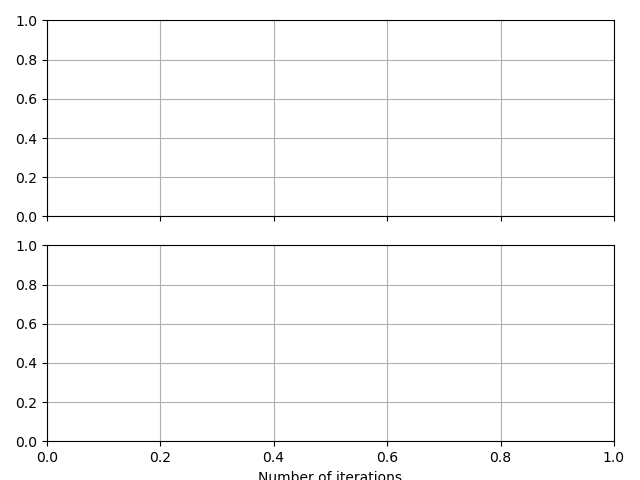

In [5]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

In [10]:
triplets = []
batch_size = 32
learning_rate = 1e-3
momentum = 0.9
margin = 0.25
num_epochs = 50

In [11]:
model = Encoder(image_id_to_desc)
optim = SGD(model.parameters, learning_rate = learning_rate, momentum = momentum)

In [ ]:
for epoch_cnt in range(num_epochs):
    
    
   
    idxs = np.arange(0, len(triplets))
    np.random.shuffle(idxs)
    
    
    for batch_cnt in range(0, len(triplets) // batch_size):
       
        # STUDENT CODE HERE
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = triplets[batch_indices]  # list of tuples with 3 indexes
    
        #prediction = model()
        
        true_caption_id = batch[:, 0] # get only captions from each tuple
        
        caption_embedding = # placeholder, need idf function for that
        
        true_image_id  = batch[:, 1]
        
        confuser_image_id  = batch[:, 2]
        
        true_img_desc = []
        conf_img_desc = []
        
        for img_id, conf_id in zip(true_image_id, confuser_image_id): 
            
            true_img_desc.append(db.ID_to_descriptor[img_id])
            conf_img_desc.append(db.ID_to_descriptor[conf_id])
            
         
        true_img_desc = np.vstack(true_img_desc)
        conf_img_desc = np.vstack(conf_img_desc)
        
        
        w_true = model(true_img_desc)
        w_confuser = model(confuser_img_desc)
        
        
        true_caption_img_similarity = caption_embedding @ w_true
        conf_caption_img_similarity = caption_embeding @ w_confuser
        
        
        
        loss = margin_ranking_loss(true_caption_img_similarity,conf_caption_img_similarity)
        
        acc = 

       
        # back-propagate through your computational graph through your loss
      
        loss.backward()
        

        # execute gradient-descent by calling step() of optim
        # STUDENT CODE HERE
        optim.step()
        
        
    
        plotter.set_train_batch({"loss" : msl.item()},
                                 batch_size=batch_size)
    